In [1]:
import numpy as np
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from torch import nn
import math
import seaborn as sns

%matplotlib inline

torch.Size([10000, 2])


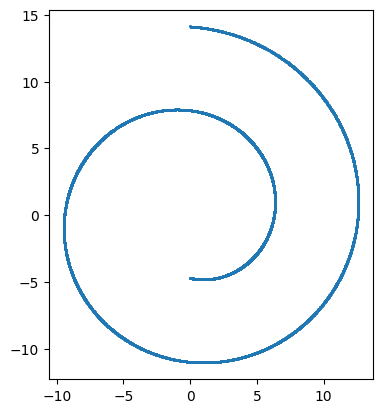

Data range: x=[-1.75, 1.61]
Data range: y=[-1.61, 2.00]


In [2]:
swiss_roll = make_swiss_roll(n_samples=10000,noise=0)[0][:,::2]
train_set = torch.tensor(swiss_roll).float()

mu, std = train_set.mean(0), train_set.std(0)
train_set = (train_set - mu)/std
print(train_set.shape)
plt.axes().set_aspect('equal')
plt.scatter(swiss_roll[:,0],swiss_roll[:,1], s=1)
plt.show()

print(f"Data range: x=[{train_set[:,0].min():.2f}, {train_set[:,0].max():.2f}]")
print(f"Data range: y=[{train_set[:,1].min():.2f}, {train_set[:,1].max():.2f}]")

loss = 2.411110: 100%|███████████████████████████████████████| 20000/20000 [01:01<00:00, 323.42it/s]


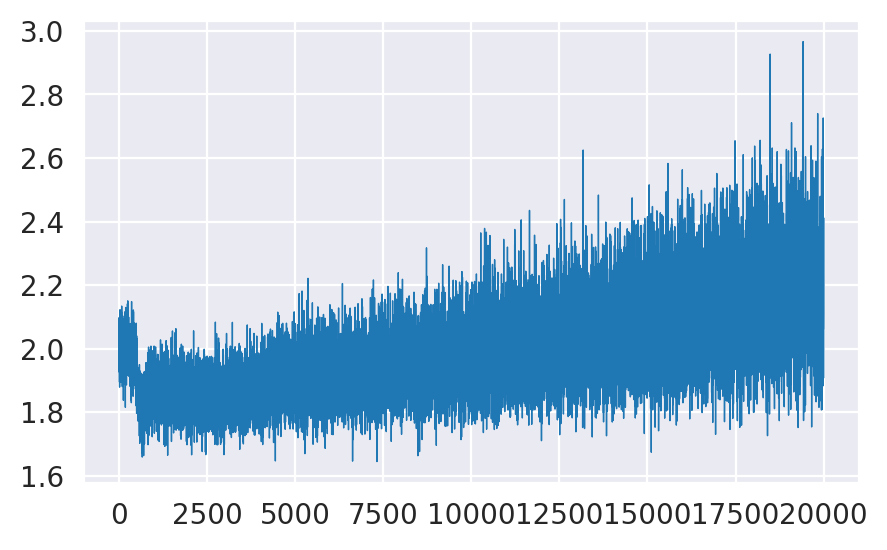

In [96]:
# Mean Flows for One-step Generative Modeling
# https://arxiv.org/pdf/2505.13447
import torch.nn.functional as F
from torch.func import jvp
# from torch.autograd.functional import jvp


def sample_t_r(batch_size, device):
    """Sample t between 0 and 1."""
    tr = torch.rand(batch_size,2, device=device)
    t = tr.max(dim=1)[0][:,None]
    r = tr.min(dim=1)[0][:,None]
    return t, r


def sample_t_r_stable(batch_size, device, min_gap=0.01):
    """Sample t and r with guaranteed minimum separation for stability"""
    # Method 1: Sample with guaranteed gap
    t = torch.rand(batch_size, 1, device=device) * (1.0 - 2*min_gap) + min_gap
    gap = torch.rand(batch_size, 1, device=device) * (t - min_gap) + min_gap
    r = t - gap

    # Ensure bounds
    t = torch.clamp(t, min_gap, 1.0 - min_gap)
    r = torch.clamp(r, 0.0, 1.0 - 2*min_gap)

    return t, r



def train_step(x, model, optimizer):
    """Our Path from Noise to Data is a straight line
    so the target is the speed "v" in closed form.
    Proof is in the paper
    """
    t,r = sample_t_r_stable(len(x), x.device)

    e = torch.randn_like(x)
    z = (1-t) * x + t * e
    v = e - x

    u, dudt = jvp(model, (z, r, t), (v, torch.zeros_like(t), torch.ones_like(t)))
    u_tgt = v - (t-r) * dudt.detach()

    loss = F.mse_loss(u, u_tgt)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    return loss




class TinyMLP(nn.Module):
    """Tiny MLP Conditioned on time"""
    def __init__(self, num_in, hidden, time_dim=16):
        super(TinyMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_in + 2 * time_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, num_in)
        )
        self.time_dim = time_dim

    @staticmethod
    def time_encoding(t, d=32):
        # Sinusoidal encoding like in transformers
        freqs = torch.exp(-math.log(10000) * torch.arange(d//2, device=t.device) / (d//2))
        args = t * freqs[None, :]
        return torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

    def forward(self, x, r, t):
        r_enc = TinyMLP.time_encoding(r, self.time_dim)
        t_enc = TinyMLP.time_encoding(t, self.time_dim)

        x_t = torch.cat((x, r_enc, t_enc), dim=1)
        return self.mlp(x_t)


def train(data, model, niter, lr):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    data = data.to(device)
    optim = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999))
    batch_size = 1000
    losses = []
    for itr in (pbar := tqdm(range(niter), ncols=100)):
        idx = torch.randperm(len(data))[:batch_size]
        x = data[idx].contiguous()
        loss = train_step(x, model, optim)
        losses.append(loss.item())
        pbar.set_description(f"loss = {loss.item():06f}")

    return losses


niter = 20000
lr = 1e-4
model = TinyMLP(2, 64, 256)
model.train()
losses = train(train_set, model, niter, lr)


with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1, figsize=(5, 3), dpi=200)
    ax.plot(np.arange(niter), losses, linewidth=0.5)
    plt.show()

Number of time steps: 6
Number of function evaluations: 32
Time points: [1.         0.93210136 0.76567809 0.49907644 0.19550813 0.        ]


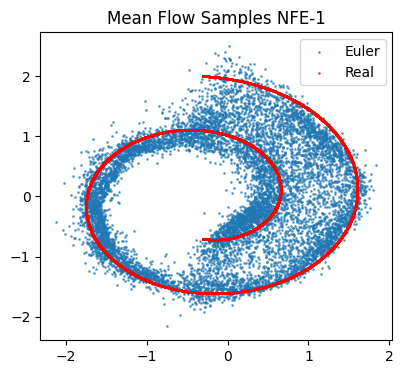

In [103]:
from scipy.integrate import solve_ivp


# 1 step sampling inference
def generate_samples_mf_nfe1(model, n_samples):
    device = next(model.parameters()).device
    z = torch.randn(n_samples, 2).to(device)
    model.eval()
    t = torch.ones((n_samples, 1), device=device)
    r = torch.zeros((n_samples, 1), device=device)
    with torch.no_grad():
        z = z - model(z, r, t)
    return z.cpu()



def generate_samples_ode(model, n_samples=1000, method='RK45', rtol=1e-2, atol=1e-3):
    """ More Sophisticated ODE Integration Dopri5 "Dormand Prince" 45, a sort of
    adaptive step size Runge-Kutta
    https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method

    """
    device = next(model.parameters()).device
    z0 = torch.randn(n_samples, 2).to(device)
    model.eval()

    r_tensor = torch.zeros((n_samples, 1), device=device)

    with torch.no_grad():
        def ode_func(t, z_flat):
            nonlocal r_tensor
            # Reshape flat array back to (n_samples, 2)
            z = torch.from_numpy(z_flat.reshape(n_samples, 2)).float().to(device)
            t_tensor = torch.full((n_samples, 1), t).to(device)

            # Get velocity from model
            v = model(z, r_tensor, t_tensor)

            r_tensor = t_tensor

            # Return as flat numpy array
            return v.cpu().numpy().flatten()

        solution = solve_ivp(
            ode_func,
            t_span=[1, 0],
            y0=z0.cpu().numpy().flatten(),
            method=method,  # 'DOP853' is 8th order Dormand-Prince
            rtol=rtol,      # Relative tolerance
            atol=atol       # Absolute tolerance
        )
        z_final = solution.y[:, -1].reshape(n_samples, 2)

        print(f"Number of time steps: {len(solution.t)}")
        print(f"Number of function evaluations: {solution.nfev}")
        print(f"Time points: {solution.t}")

    return torch.from_numpy(z_final)



# samples = generate_samples_mf_nfe1(model, 10000)
samples = generate_samples_ode(model, 10000)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=1, label='Euler')
plt.scatter(train_set[:, 0], train_set[:, 1], alpha=0.6, s=1, color='red', label='Real')
plt.legend()
plt.title('Mean Flow Samples NFE-1')
plt.show()